# 1 Introduction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1.1 What does your theory say about your data?

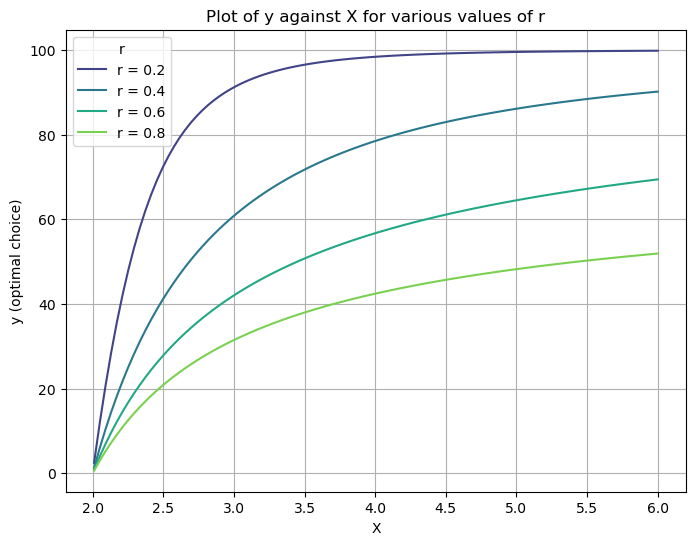

In [3]:
X = np.linspace(2.01, 6, num=100)
r = np.array([0.2,0.4,0.6,0.8])
X_grid, r_grid = np.meshgrid(X, r)

dplt1 = pd.DataFrame({
    'X': X_grid.ravel(),
    'r': r_grid.ravel(),
})

dplt1['y'] = 100 * (1 - (dplt1['X'] - 1) ** (-1/dplt1['r'])) / ((dplt1['X'] - 1) ** (1 - 1/dplt1['r']) + 1)
dplt1['r'] = 'r = ' + dplt1['r'].astype(str)

plt.figure(figsize=(8, 6))
sns.lineplot(data=dplt1, x='X', y='y', hue='r', palette='viridis')
plt.xlabel('X')
plt.ylabel('y (optimal choice)')
plt.title('Plot of y against X for various values of r')
plt.grid(True)
plt.show()